# dAiv AI_Competition[2024]_Pro Baseline for PyTorch

## Import Libraries

In [1]:
from os import path, rename, mkdir, listdir

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets, utils, models
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

datasets.utils.tqdm = tqdm
%matplotlib inline

### Check GPU Availability

In [2]:
!nvidia-smi

Thu Oct 31 11:07:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |    679MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 7
device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [4]:
from typing import Callable, Optional
from sklearn.model_selection import train_test_split


class ImageDataset(datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_pro/dataset/archive.zip"
    random_state = 20241028

    def __init__(
            self, root: str, force_download: bool = True,
            train: bool = False, valid: bool = False, split_ratio: float = 0.8,
            test: bool = False, unlabeled: bool = False,
            transform: Optional[Callable] = None, target_transform: Optional[Callable] = None
    ):
        self.download(root, force=force_download)  # Download Dataset from server

        if train or valid:  # Set-up directory
            root = path.join(root, "train")
        else:
            root = path.join(root, "test" if test else "unlabeled" if unlabeled else None)

        # Initialize ImageFolder
        super().__init__(root=root, transform=transform, target_transform=target_transform)

        if train or valid:  # Split Train and Validation Set
            seperated = train_test_split(
                self.samples, self.targets, test_size=1-split_ratio, stratify=self.targets, random_state=self.random_state
            )
            self.samples, self.targets = (seperated[0], seperated[2]) if train else (seperated[1], seperated[3])
            self.imgs = self.samples

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "archive.zip")):
            # Download and Extract Dataset
            datasets.utils.download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="archive.zip")
            
            # Arrange Dataset Directory
            for target_dir in [path.join(root, "test"), path.join(root, "unlabeled")]:
                for file in listdir(target_dir):
                    mkdir(path.join(target_dir, file.replace(".jpg", "")))
                    rename(path.join(target_dir, file), path.join(target_dir, file.replace(".jpg", ""), file))

            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

### Dataset Initialization

In [5]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (256, 256)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [6]:
DATA_ROOT = path.join(".", "data")

train_dataset = ImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = ImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)

test_dataset = ImageDataset(root=DATA_ROOT, force_download=False, test=True, transform=resizer)
unlabeled_dataset = ImageDataset(root=DATA_ROOT, force_download=False, unlabeled=True, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)}), Unlabeled({len(unlabeled_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(7478), Valid(1870), Test(1110), Unlabeled(380)


## Data Augmentation if needed

In [7]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [8]:
train_dataset = ImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)}), Unlabeled({len(unlabeled_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(7478), Unlabeled(380)


In [9]:
unlabeled_dataset = ImageDataset(root=DATA_ROOT, force_download=False, unlabeled=True, transform=augmenter)

print(f"INFO: Unlabeled dataset has been overridden with augmented state. Number of samples - Unlabeled({len(unlabeled_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Unlabeled dataset has been overridden with augmented state. Number of samples - Unlabeled(380)


## DataLoader

In [10]:
# Set Batch Size
BATCH_SIZE = 128

In [11]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


In [12]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = np.array(image_list).transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)

In [13]:
# images, targets = next(iter(train_loader))
# grid_images = utils.make_grid(images, nrow=8, padding=10)
# imshow(grid_images)

In [14]:
# images, _ = next(iter(unlabeled_loader))
# grid_images = utils.make_grid(images, nrow=8, padding=10)
# imshow(grid_images)

## Define Model

In [15]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super(SelfAttention, self).__init__()
        self.heads = heads
        inner_dim = dim_head * heads
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.scale = dim_head ** -0.5
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.reshape(b, n, h, -1).transpose(1, 2).clone(), qkv)

        # Scaled Dot-Product Attention with softmax
        dots = (q @ k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1).clone()  # Ensure out-of-place operation

        # Attention output
        out = (attn @ v).transpose(1, 2).reshape(b, n, -1)
        return self.to_out(out.clone())  # Ensure out-of-place operation

In [16]:
class SecondMaxLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.clone()
        max_val, max_idx = torch.max(x, dim=1, keepdim=True)
        x.scatter_(1, max_idx, 1e-12)
        return x

In [17]:
from gradient_reversal import GradientReversal

class ImageClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes: int):
        super().__init__()
        self.multiple_output = False

        # 특징 추출기 (ResNet 백본)
        self.resnet = models.resnet34(pretrained=True)
        self.fc_size = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.fc_size, hidden_size)
        
        # self.attention_layer = SelfAttention(hidden_size, heads=8, dim_head=64)

        # 도메인 분류기 - 병목 구조 적용
        self.domain_classifier_with_grl = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 4, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, 1)
        )
        
        # GRL이 적용되지 않은 특징을 위한 도메인 분류기
        self.domain_classifier_without_grl = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 4, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, 1)
        )


        # 출력 레이어 - 최종 예측을 위한 메인 분류기
        self.classifier = nn.Linear(hidden_size, num_classes)

        # 멀티라벨 분류를 위한 보조 분류기 (필요할 경우 사용)
        self.secondary = SecondMaxLayer()

    def toggle_multilabel(self, multi_label: bool | None = None):
        if isinstance(multi_label, bool):
            self.multiple_output = multi_label
        else:
            self.multiple_output = not self.multiple_output

    def forward(self, x, lambda_grl=1.0, return_features=False):
        # ResNet을 통한 특징 추출
        extracted = self.resnet(x)
        # attended_features = self.attention_layer(extracted.unsqueeze(1)).squeeze(1)

        # 메인 분류기의 출력
        out = self.classifier(extracted)

        grl_layer = GradientReversal(lambda_grl)
        reversed_features = grl_layer(extracted)
        
        # GRL통과 도메인 분류기
        domain = torch.sigmoid(self.domain_classifier_with_grl(reversed_features))
        # 추론과정에서의 단일라벨과 멀티라벨 분류를 위한 도메인 분류기
        detached_features = extracted.detach()
        domain_no_grl = torch.sigmoid(self.domain_classifier_without_grl(detached_features))
    
        # 멀티라벨 출력이 활성화된 경우
        if self.multiple_output:
            return domain, domain_no_grl, out, self.secondary(out)

        if return_features:
            # 임베딩 벡터와 함께 반환
            return domain, domain_no_grl, out, reversed_features, extracted

        # 도메인과 메인 분류기 출력 반환
        return domain, domain_no_grl, out

In [18]:
CLASS_LABELS = len(train_dataset.classes)

MODEL_PARAMS = dict(
    hidden_size=512, num_classes=CLASS_LABELS
)

In [19]:
# Initialize Model
model = ImageClassifier(**MODEL_PARAMS)
model_id = 'DCwithAttention'
model.to(device)

/shared_hdd/rnoro5122/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared_hdd/rnoro5122/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ImageClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [20]:
LEARNING_RATE = 1e-4

# 손실 함수 정의
domain_criterion = nn.BCELoss() # 도메인 분류 손실 함수

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

## Training Loop

In [21]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [22]:
def save_model(model_id: str, acc: float, loss: float, epoch: int | None = None) -> None:
    dir_path: str =  path.join(".", "models", "backup") if epoch else path.join(".", "models")
    if not path.isdir(dir_path):
        mkdir(dir_path)
    
    if epoch:
        model_info: str = f"{epoch:02}__{model_id}__acc__{acc:.6f}__loss__{loss:.6f}" 
    else: 
        model_info = f"{model_id}__acc__{acc:.6f}__loss__{loss:.6f}"    
    
    save_path: str = path.join(dir_path, f"{model_info}.pt")
    torch.save(model.state_dict(), save_path)

    if not epoch:
        print(f"Model saved to {save_path}")

In [23]:
# Set Epoch Count
num_epochs = 5

In [24]:
train_length, valid_length = map(len, (train_loader, valid_loader))

import itertools

domain_weight = 1.0  # 도메인 loss 가중치
domain_no_grl_weight = 1.0

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
      tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        model.toggle_multilabel(False)

        # 무한 반복 이터레이터 생성
        unlabeled_iter = iter(itertools.cycle(unlabeled_loader))

        for i, (inputs_source, targets_source) in enumerate(train_loader):
            optimizer.zero_grad()

            # 소스 도메인 데이터 설정
            inputs_source = inputs_source.to(device, non_blocking=True)
            targets_source = targets_source.to(device, non_blocking=True)
            domain_label_source = torch.zeros(inputs_source.size(0), 1, device=device)  # 소스 도메인 레이블: 0

            # 타겟 도메인 데이터 가져오기
            inputs_target, _ = next(unlabeled_iter)
            inputs_target = inputs_target.to(device, non_blocking=True)
            domain_label_target = torch.ones(inputs_target.size(0), 1, device=device)  # 타겟 도메인 레이블: 1

            lambda_grl = 1.0

            # 모델 출력 계산
            # 소스 도메인 데이터에서 분류와 도메인 분류 출력
            domain_outputs_source, domain_outputs_source_no_grl, outputs_source = model(inputs_source, lambda_grl)
            # 타겟 도메인 데이터에서 도메인 분류 출력 (레이블 없음)
            domain_outputs_target, domain_outputs_target_no_grl, _ = model(inputs_target, lambda_grl)

            # 손실 함수 계산
            # 분류 손실 (소스 도메인 데이터에 대해서만)
            classification_loss = criterion(outputs_source, targets_source)

            # 도메인 분류 손실 (소스와 타겟 도메인 모두)
            domain_outputs = torch.cat([domain_outputs_source, domain_outputs_target], dim=0)
            domain_outputs_no_grl = torch.cat([domain_outputs_source_no_grl, domain_outputs_target_no_grl], dim=0)
            domain_labels = torch.cat([domain_label_source, domain_label_target], dim=0)

            domain_classification_loss = domain_criterion(domain_outputs, domain_labels)
            domain_classification_no_grl_loss = domain_criterion(domain_outputs_no_grl, domain_labels)

            # 총 손실 계산 (분류 손실 + 가중치를 적용한 도메인 분류 손실)
            loss = classification_loss + domain_weight * domain_classification_loss + domain_no_grl_weight * domain_classification_no_grl_loss

            # 역전파 및 옵티마이저 스텝
            loss.backward()
            optimizer.step()

            # Progress Bar 업데이트 및 출력
            update(loss)
            train_progress.update(1)
            print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{i+1:3}/{train_length}], Loss: {loss.item():.6f}", end="")

        val_acc, val_loss, val_domain_acc, total_batches = 0, 0, 0, 0

        # Validation
        model.eval()
        model.toggle_multilabel(False)
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                domain_outputs, domain_outputs_no_grl, outputs = model(inputs)

                # 분류 손실 계산
                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum().item() / len(valid_dataset)

                # 도메인 분류기 정확도 계산
                domain_preds = (domain_outputs_no_grl >= 0.5).float()  # 0.5 미만일 때 소스 도메인(0)으로 예측
                domain_labels = torch.zeros(inputs.size(0), 1).to(device)  # Validation 데이터는 소스 도메인으로 가정
                val_domain_acc += (domain_preds == domain_labels).sum().item()  # 정확도 누적
                total_batches += inputs.size(0)  # 배치 수 누적

                valid_progress.update(1)

        # 최종 도메인 분류 정확도 계산
        val_domain_acc /= total_batches  # 배치 수로 나눠 평균 계산

        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}, Domain Acc: {val_domain_acc:.6%}", end="\n")

Running Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/59 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

Output()

Epoch [ 1/5], Step [59/59], Loss: 3.307225, Valid Acc: 62.513369%, Valid Loss: 1.788804, Domain Acc: 85.240642%
Epoch [ 2/5], Step [59/59], Loss: 2.874332, Valid Acc: 74.171123%, Valid Loss: 1.141869, Domain Acc: 64.545455%


Process Process-328:
Exception ignored in: <function _releaseLock at 0x7fc7e94df380>
Traceback (most recent call last):
  File "/shared_hdd/rnoro5122/anaconda3/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
Traceback (most recent call last):
  File "/shared_hdd/rnoro5122/anaconda3/lib/python3.12/multiprocessing/process.py", line 307, in _bootstrap
    self._after_fork()
  File "/shared_hdd/rnoro5122/anaconda3/lib/python3.12/multiprocessing/context.py", line 228, in _after_fork
    return _default_context.get_context().Process._after_fork()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/shared_hdd/rnoro5122/anaconda3/lib/python3.12/multiprocessing/process.py", line 342, in _after_fork
    util._run_after_forkers()
KeyboardInterrupt
  File "/shared_hdd/rnoro5122/anaconda3/lib/python3.12/multiprocessing/util.py", line 170, in _run_after_forkers
    func(obj)


RuntimeError: DataLoader worker (pid(s) 17287, 17336, 17390, 17450, 17501, 17562, 17610, 17663, 17716, 17772, 17829, 17951, 18019, 18075, 18147, 18211, 18282, 18503, 18559, 18621, 18669, 18721, 18774, 18823, 18888, 18944, 18993, 19078, 19141, 19206, 19299, 19352, 19466, 19641, 19695, 19753, 19825, 19873, 19941, 20009) exited unexpectedly

In [25]:
if not path.isdir(path.join(".", "models")):
    mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"{model_id}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./models/DCwithAttention.pt


# Model Evaluation

In [26]:
# Load Model
model = ImageClassifier(**MODEL_PARAMS)
model.load_state_dict(torch.load(path.join("./models", f"{model_id}.pt")))
model.to(device)

/tmp/ipykernel_39076/404286516.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path.join("./models", f"{model_id}.pt")))


ImageClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [27]:
import torch.nn.functional as F

results = dict(id=[], label1=[], label2=[])
test_length = len(test_dataset)
output_threshold = 0 # outputs2에 대한 임계값 설정
domain_threshold = 0.5

model.eval()
model.toggle_multilabel(True)
with torch.no_grad():
    total_single = 0
    total_multi = 0
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        domain, domain_no_grl, outputs1, outputs2 = model(inputs)
        

        # outputs2에 소프트맥스 적용
        outputs2_prob = F.softmax(outputs2, dim=1)  # 각 클래스에 대한 확률 계산

        print(domain_no_grl)

        # label1 처리
        preds1 = []
        preds2 = []
        for i in range(domain.size(0)):
            if domain_no_grl[i].item() <= domain_threshold:
                # 소스 도메인: 단일 레이블 (-1)
                preds1.append(-3)
                # outputs1에 기반하여 preds2 설정
                preds2.append(torch.max(outputs1[i], 0)[1].item())
                total_single += 1
            else:
                # 타겟 도메인: 멀티레이블 추론 수행
                max_val2, max_idx2 = torch.max(outputs2_prob[i], 0)  # 확률 값으로 비교

                if max_val2.item() >= output_threshold:
                    # outputs2가 임계값 이상일 때, 멀티레이블 추론
                    preds1.append(torch.max(outputs1[i], 0)[1].item())
                    preds2.append(max_idx2.item())

                    # preds1.append(-3)
                    # preds2.append(-3)
                    total_multi += 1
                else:
                    # outputs2가 임계값 이하일 때, 단일 레이블로 간주
                    preds1.append(-1)  # 단일 레이블 (-1)
                    preds2.append(torch.max(outputs1[i], 0)[1].item())
                    total_single += 1

        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label1'] += preds1
        results['label2'] += preds2

    print(f"single label: {total_single}, multi label: {total_multi}")

  0%|          | 0/9 [00:00<?, ?it/s]

tensor([[0.4616],
        [0.4344],
        [0.4909],
        [0.4186],
        [0.5348],
        [0.5103],
        [0.5028],
        [0.4685],
        [0.4415],
        [0.5466],
        [0.5314],
        [0.4915],
        [0.4827],
        [0.5481],
        [0.5128],
        [0.6107],
        [0.5232],
        [0.5056],
        [0.4818],
        [0.4771],
        [0.5921],
        [0.6063],
        [0.5321],
        [0.5617],
        [0.5313],
        [0.5235],
        [0.6021],
        [0.5660],
        [0.4802],
        [0.5447],
        [0.4983],
        [0.4728],
        [0.4390],
        [0.5841],
        [0.5137],
        [0.3380],
        [0.5692],
        [0.5397],
        [0.5558],
        [0.5563],
        [0.5147],
        [0.4251],
        [0.5121],
        [0.5666],
        [0.3717],
        [0.3560],
        [0.5951],
        [0.4945],
        [0.6164],
        [0.4960],
        [0.5406],
        [0.4365],
        [0.5815],
        [0.5472],
        [0.5052],
        [0

In [28]:
# Re-arrange Results
for i, labels in enumerate(zip(results['label1'], results['label2'])):
    results['label1'][i], results['label2'][i] = min(labels), max(labels)

results_df = pd.DataFrame(results)
results_df

,id,label1,label2
0,TEST_00000,-3,57
1,TEST_00001,-3,117
2,TEST_00002,-3,94
3,TEST_00003,-3,16
4,TEST_00004,80,81
...,...,...,...
1105,TEST_01105,-3,2
1106,TEST_01106,66,67
1107,TEST_01107,-3,24
1108,TEST_01108,-3,29


In [29]:
# Save Results
submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"submission.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

File saved to submissions/submission.csv


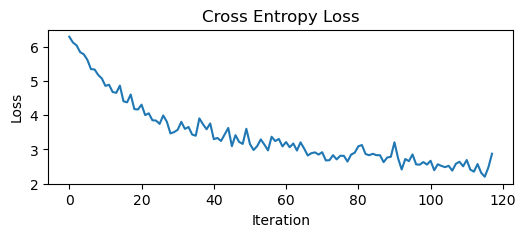

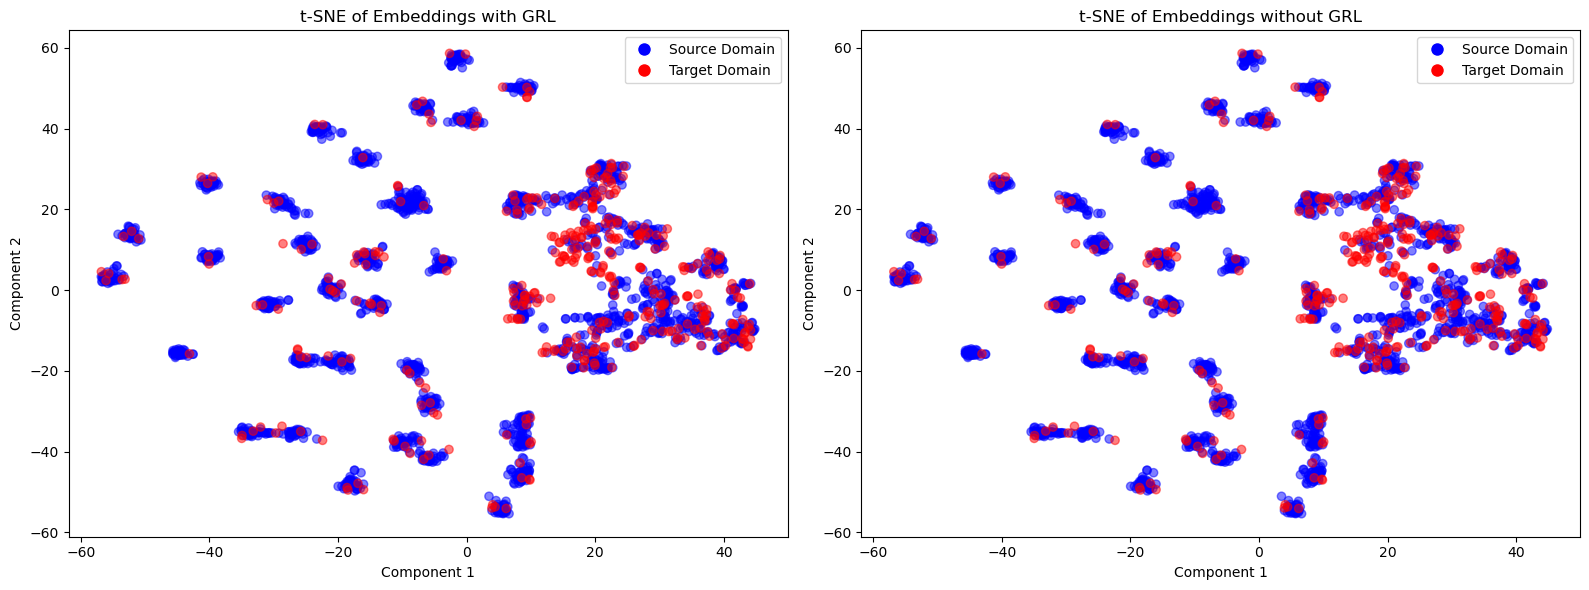

In [29]:
import numpy as np

model.eval()
model.toggle_multilabel(False)

# 임베딩 벡터와 레이블을 저장할 리스트 초기화
features_with_grl = []
features_without_grl = []
domain_labels = []

# 소스 도메인 데이터 (Validation 데이터 사용)
with torch.no_grad():
    for inputs, _ in valid_loader:
        inputs = inputs.to(device)
        domain_label = torch.zeros(inputs.size(0), 1)  # 소스 도메인 레이블: 0

        # 모델 출력 계산 (임베딩 벡터 반환)
        domain_outputs, domain_outputs_no_grl, outputs, reversed_features, detached_features = model(inputs, return_features=True)

        # CPU로 이동하여 numpy 배열로 변환
        reversed_features_np = reversed_features.cpu().numpy()
        detached_features_np = detached_features.cpu().numpy()
        domain_labels_np = domain_label.cpu().numpy()

        # 리스트에 추가
        features_with_grl.append(reversed_features_np)
        features_without_grl.append(detached_features_np)
        domain_labels.append(domain_labels_np)

# 타겟 도메인 데이터
with torch.no_grad():
    for inputs, _ in unlabeled_loader:
        inputs = inputs.to(device)
        domain_label = torch.ones(inputs.size(0), 1)  # 타겟 도메인 레이블: 1

        # 모델 출력 계산 (임베딩 벡터 반환)
        domain_outputs, domain_outputs_no_grl, outputs, reversed_features, detached_features = model(inputs, return_features=True)

        # CPU로 이동하여 numpy 배열로 변환
        reversed_features_np = reversed_features.cpu().numpy()
        detached_features_np = detached_features.cpu().numpy()
        domain_labels_np = domain_label.cpu().numpy()

        # 리스트에 추가
        features_with_grl.append(reversed_features_np)
        features_without_grl.append(detached_features_np)
        domain_labels.append(domain_labels_np)

# 리스트를 배열로 변환
features_with_grl = np.concatenate(features_with_grl, axis=0)
features_without_grl = np.concatenate(features_without_grl, axis=0)
domain_labels = np.concatenate(domain_labels, axis=0).flatten()

# 3. 차원 축소 (t-SNE 사용)

from sklearn.manifold import TSNE

# t-SNE 모델 생성
tsne = TSNE(n_components=2, random_state=42)

# GRL이 적용된 임베딩 벡터 차원 축소
tsne_results_with_grl = tsne.fit_transform(features_with_grl)

# GRL이 적용되지 않은 임베딩 벡터 차원 축소
tsne_results_without_grl = tsne.fit_transform(features_without_grl)

# 4. 시각화

import matplotlib.pyplot as plt

# 도메인 레이블에 따라 색상 지정
domain_colors = ['blue' if label == 0 else 'red' for label in domain_labels]

# 그림 크기 설정
plt.figure(figsize=(16, 6))

# GRL이 적용된 임베딩 벡터 시각화
plt.subplot(1, 2, 1)
plt.scatter(tsne_results_with_grl[:, 0], tsne_results_with_grl[:, 1], c=domain_colors, alpha=0.5)
plt.title('t-SNE of Embeddings with GRL')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(handles=[plt.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Source Domain'),
                    plt.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Target Domain')])

# GRL이 적용되지 않은 임베딩 벡터 시각화
plt.subplot(1, 2, 2)
plt.scatter(tsne_results_without_grl[:, 0], tsne_results_without_grl[:, 1], c=domain_colors, alpha=0.5)
plt.title('t-SNE of Embeddings without GRL')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(handles=[plt.Line2D([], [], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Source Domain'),
                    plt.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label='Target Domain')])

plt.tight_layout()
plt.show()
